In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import auc as auc_calc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve,precision_recall_curve
from ucimlrepo import fetch_ucirepo 
from lightgbm import LGBMClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


# データ整備

In [2]:
# Load the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape,test.shape)
train["data"]="train"
test["data"]="test"
target="Response"
test[target]=-1
data=pd.concat([train.sample(frac=0.01),test]).reset_index(drop=True)


(11504798, 12) (7669866, 11)


In [3]:
cat_col=["Gender","Driving_License","Region_Code",
        "Previously_Insured","Vehicle_Age","Vehicle_Damage","Policy_Sales_Channel",
        ]
num_col=["Age","Annual_Premium","Vintage"]

In [4]:
data["Age_segment"]=pd.cut(data["Age"],bins=np.arange(20,100,10),labels=np.arange(20,90,10),right=False)
data['Annual_Premium_segment']=np.where(data["Annual_Premium"]<10000,1,0)
# cat_col.append("Age_segment")
# cat_col.append('Annual_Premium_segment')

In [5]:
def cat_feature(data_input):
    global cat_col
    df=data_input.copy()
    # for c in [["Previously_Insured","Vehicle_Damage"],
    #           ["Previously_Insured","Vehicle_Age"],
    #           ["Previously_Insured","Age_segment"],
    #           ["Previously_Insured","Annual_Premium_segment"],
    #           ["Previously_Insured","Policy_Sales_Channel"]
    #           ]:
    #     df[c[0]+"_"+c[1]]=df[c[0]].astype(str)+"_"+df[c[1]].astype(str)
    for i,i_col in enumerate(cat_col):
        for j,j_col in enumerate(cat_col):
            df[f"{i_col}_{j_col}"]=df[f"{i_col}"].astype(str)+"_"+df[f"{j_col}"].astype(str)
    cat_col+=list(set(df.columns)-set(data_input.columns))
    return df

data_new_feature=cat_feature(data)


In [ ]:

def new_features(data_input):
    global cat_col
    df=data_input.copy()
    # cat_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
    # df[cat_features] = df[cat_features].astype('category')
    # df["Vehicle_Age"] = df["Vehicle_Age"].cat.rename_categories({"1-2 Year": 1, "< 1 Year": 0, "> 2 Years": 2}).astype('int8')
    # df['Gender'] = df['Gender'].cat.rename_categories({'Male': 0, 'Female': 1}).astype('int8')
    # df['Vehicle_Damage'] = df['Vehicle_Damage'].cat.rename_categories({'No': 0, 'Yes': 1}).astype('int8')
    label_encoders = {}
    for col in cat_col:
        le= LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df
#data_new_feature=new_features(data)
data_new_feature=new_features(data_new_feature)

In [ ]:
def new_features2(data_input):
    global  num_col,cat_col
    df=data_input.copy()
    
    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Policy_Sales_Channel', 'Previously_Insured'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_channel_insured_{metric.lower()}' for x in group.columns]
        df = pd.merge(df, group, on=['Policy_Sales_Channel', 'Previously_Insured'], how='left')

    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Region_Code', 'Previously_Insured'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_region_insured_{metric.lower()}' for x in group.columns]
        df = pd.merge(df, group, on=['Region_Code', 'Previously_Insured'], how='left')

    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Region_Code', 'Vehicle_Damage'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_region_damage_{metric.lower()}' for x in group.columns]
        df = pd.merge(df, group, on=['Region_Code', 'Vehicle_Damage'], how='left')

    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Vehicle_Damage'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_damage_{metric.lower()}' for x in group.columns]
        df = pd.merge(df, group, on=['Vehicle_Damage'], how='left')

    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Age', 'Vehicle_Damage'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_age_damage_{metric.lower()}' for x in group.columns]
        df = pd.merge(df, group, on=['Age', 'Vehicle_Damage'], how='left')
    group = df.groupby(['Age']).agg(cnt_age_insured=('Previously_Insured', 'count'))
    df = pd.merge(df, group, on=['Age'], how='left')
    group = df.groupby(['Region_Code']).agg(cnt_region_insured=('Previously_Insured', 'count'))
    df = pd.merge(df, group, on=['Region_Code'], how='left')
    num_col+=list(set(df.columns)-set(data_input.columns))
    return df 

data_new_feature=new_features2(data_new_feature)

In [ ]:
def new_features4(data_input):
    global  num_col,cat_col
    df=data_input.copy()
    
    for col in ["Age","Annual_Premium","Vintage"]:
        group=df.groupby('Region_Code')[col].mean().rename(f"Region_{col}_mean").reset_index()
        #print(group)
        df=pd.merge(df,group,on='Region_Code',how="outer")
        group=df.groupby('Policy_Sales_Channel')[col].mean().rename(f"Channel_{col}_mean").reset_index()
        df=pd.merge(df,group,on='Policy_Sales_Channel',how="outer")
    num_col+=list(set(df.columns)-set(data_input.columns))
    return df
data_new_feature=new_features4(data_new_feature)

In [ ]:
df_train=data_new_feature[data_new_feature["data"]=="train"].drop(columns=["data"])
df_test=data_new_feature[data_new_feature["data"]=="test"].drop(columns=["data",'Response'])

In [ ]:
num_col+cat_col

['Age',
 'Annual_Premium',
 'Vintage',
 'mean_region_insured_vintage',
 'std_region_insured_vintage',
 'mean_region_damage_annual_premium',
 'mean_damage_annual_premium',
 'std_channel_insured_annual_premium',
 'mean_region_damage_vintage',
 'cnt_age_insured',
 'mean_channel_insured_vintage',
 'mean_age_damage_vintage',
 'std_damage_annual_premium',
 'std_region_damage_vintage',
 'mean_damage_vintage',
 'std_age_damage_annual_premium',
 'std_region_insured_annual_premium',
 'std_age_damage_vintage',
 'mean_channel_insured_annual_premium',
 'std_damage_vintage',
 'cnt_region_insured',
 'mean_region_insured_annual_premium',
 'mean_age_damage_annual_premium',
 'std_channel_insured_vintage',
 'std_region_damage_annual_premium',
 'Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel']

In [ ]:
# Separate features and target
df_train=df_train.sort_values(by=["id"]).reset_index(drop=True)
df_test = df_test.sort_values(by=["id"]).reset_index(drop=True)
X = df_train.drop(columns=['Response',"id"])[num_col+cat_col]
y = df_train['Response']
test_x=df_test.copy().drop(columns=["id"])[num_col+cat_col]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import RidgeClassifier
# LightGBMモデル
clf = LGBMClassifier()
clf = RidgeClassifier()
# 前進選択法の設定
sfs = SFS(clf, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='roc_auc', 
          cv=5,
          n_jobs=-1)

# 前進選択法の実行

sfs = sfs.fit(, y)

# 選ばれた特徴量
selected_features = sfs.k_feature_names_
print("選ばれた特徴量:", selected_features)

# 選ばれた特徴量を用いたモデルの評価
X_selected = sfs.transform(X)
scores = cross_val_score(lgbm, X_selected, y, cv=5, scoring='roc_auc', n_jobs=-1)
print("クロスバリデーションROC AUCスコア:", scores.mean())

MemoryError: Unable to allocate 87.8 MiB for an array with shape (11504798,) and data type int64

# OOF

In [12]:
# # アウトオブフォールド予測の収集
def get_out_of_fold_predictions(X_input, y_input,test_input,params_input,n_splits=5):
    # GroupKFoldの初期化\
    oof_predictions = np.zeros([X.shape[0]])
    oof_test = np.zeros((test_input.shape[0], n_splits))
    aucs = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    # 各分割のデータインデックスを出力
    for fold, (train_idx, val_index) in enumerate(skf.split(X_input, y_input)):
        print(f"Fold {fold + 1}")
        # データを分割
        X_train, X_val = X_input.iloc[train_idx], X_input.iloc[val_index]
        y_train, y_val = y_input.iloc[train_idx], y_input.iloc[val_index]


        # LGBMClassifierの初期化
        evals_result = {} 
        model = XGBClassifier(**params_input, importance_type='gain')
        # モデルのトレーニング
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],  verbose=True)
        # モデルのトレーニング
        
        y_pred = model.predict_proba(X_val)[:,1]
        
        # 精度の計算
        auc = roc_auc_score(y_val, y_pred)
        print(f'AUC: {auc:.4f}')
        aucs.append(auc)
        
        oof_predictions[val_index] = y_pred
        oof_test[:,fold]=model.predict_proba(test_input)[:,1]
        if fold==0:
            results=model.evals_result()
            epochs = len(results['validation_0']['auc'])
            x_axis = range(0, epochs)
            plt.figure(figsize=(10, 6))
            plt.plot(x_axis, results['validation_0']['auc'], label='Train')
            plt.plot(x_axis, results['validation_1']['auc'], label='Test')
            plt.xlabel('Epochs')
            plt.ylabel('AUC')
            plt.title('XGBoost AUC Learning Curve')
            plt.legend()
            plt.show()


            # 特徴量の重要度のプロット
            plt.figure(figsize=(10, 6))
            xgb.plot_importance(model, importance_type='gain', max_num_features=20)
            plt.title('Feature Importance')
            plt.show()

            # ROC曲線を計算
            fpr, tpr, thresholds = roc_curve(y_val, y_pred)
            # AUCを計算
            roc_auc = auc_calc(fpr, tpr)
            # ROC曲線をプロット
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()
            
            precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
            pr_curve_auc = auc_calc(recall, precision)
            plt.plot(recall, precision, label='PR curve (area = %.2f)'%pr_curve_auc)
            plt.legend()
            plt.title('PR curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.grid(True)
            plt.show()
            
    # 平均精度の表示
    mean_accuracy = np.mean(aucs)
    print(f"Mean accuracy: {mean_accuracy:.4f}")
    print(aucs)
    return oof_predictions,oof_test


Fold 1


c:\Users\hmhm0\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.66611	validation_1-auc:0.65755
[1]	validation_0-auc:0.74846	validation_1-auc:0.74345
[2]	validation_0-auc:0.75448	validation_1-auc:0.74897
[3]	validation_0-auc:0.77800	validation_1-auc:0.77306
[4]	validation_0-auc:0.84349	validation_1-auc:0.83998
[5]	validation_0-auc:0.85564	validation_1-auc:0.85308
[6]	validation_0-auc:0.86211	validation_1-auc:0.86016
[7]	validation_0-auc:0.87010	validation_1-auc:0.86810
[8]	validation_0-auc:0.86824	validation_1-auc:0.86626
[9]	validation_0-auc:0.86611	validation_1-auc:0.86410
[10]	validation_0-auc:0.87165	validation_1-auc:0.86987
[11]	validation_0-auc:0.87143	validation_1-auc:0.86907
[12]	validation_0-auc:0.86943	validation_1-auc:0.86711
[13]	validation_0-auc:0.86620	validation_1-auc:0.86386
[14]	validation_0-auc:0.86939	validation_1-auc:0.86726
[15]	validation_0-auc:0.87299	validation_1-auc:0.87103
[16]	validation_0-auc:0.87556	validation_1-auc:0.87351
[17]	validation_0-auc:0.87420	validation_1-auc:0.87215
[18]	validation_0-au

c:\Users\hmhm0\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\hmhm0\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the d

AUC: 0.8896


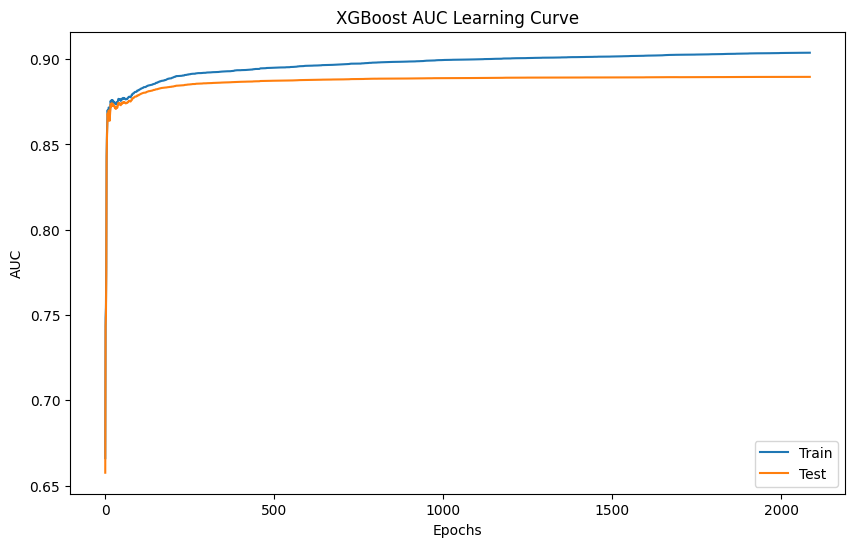

<Figure size 1000x600 with 0 Axes>

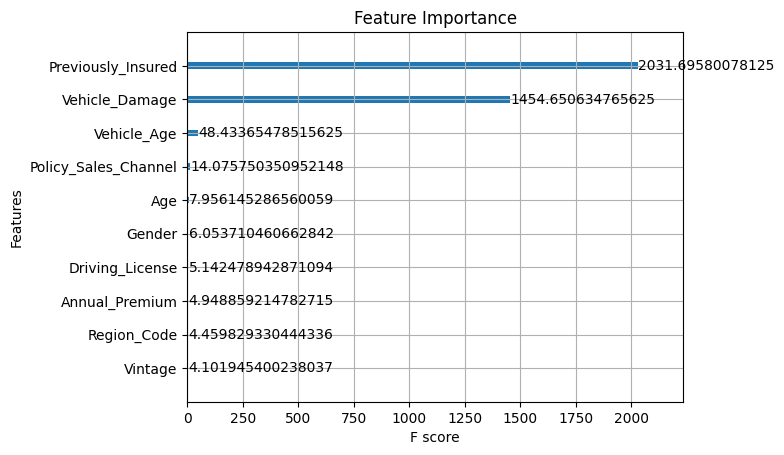

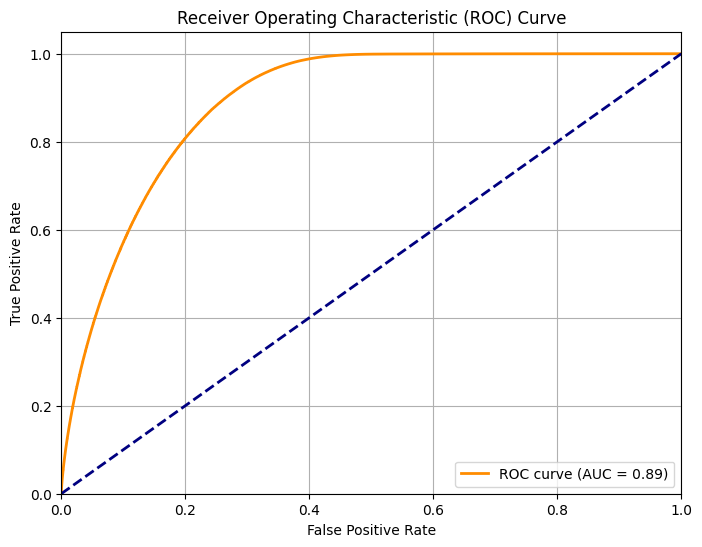

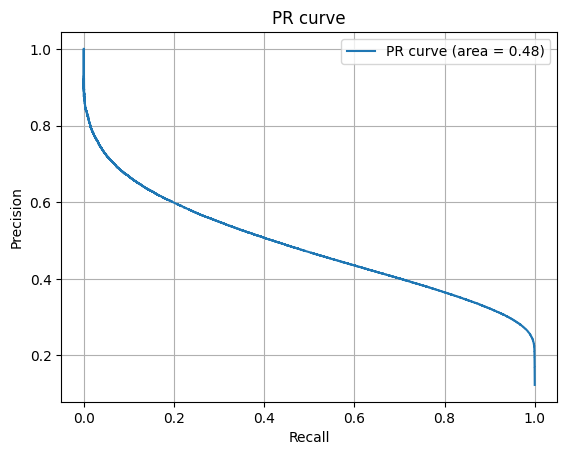

Fold 2


c:\Users\hmhm0\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.66594	validation_1-auc:0.65920
[1]	validation_0-auc:0.74788	validation_1-auc:0.74464
[2]	validation_0-auc:0.75355	validation_1-auc:0.74964
[3]	validation_0-auc:0.77737	validation_1-auc:0.77381
[4]	validation_0-auc:0.84308	validation_1-auc:0.84080
[5]	validation_0-auc:0.85500	validation_1-auc:0.85331
[6]	validation_0-auc:0.86157	validation_1-auc:0.86025
[7]	validation_0-auc:0.86954	validation_1-auc:0.86839
[8]	validation_0-auc:0.86763	validation_1-auc:0.86670
[9]	validation_0-auc:0.86551	validation_1-auc:0.86466
[10]	validation_0-auc:0.87104	validation_1-auc:0.87033
[11]	validation_0-auc:0.87063	validation_1-auc:0.86944
[12]	validation_0-auc:0.86863	validation_1-auc:0.86749
[13]	validation_0-auc:0.86540	validation_1-auc:0.86431
[14]	validation_0-auc:0.86863	validation_1-auc:0.86766
[15]	validation_0-auc:0.87220	validation_1-auc:0.87131
[16]	validation_0-auc:0.87507	validation_1-auc:0.87410
[17]	validation_0-auc:0.87371	validation_1-auc:0.87272
[18]	validation_0-au

c:\Users\hmhm0\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


AUC: 0.8893
Mean accuracy: 0.8895
[0.8896096072999159, 0.8893196537047123]


In [14]:

# params = {
# 'objective': 'binary:logistic',
# 'eval_metric': 'auc',
# 'enable_categorical': True,
# 'n_estimators': 10000,
# 'eta': 0.05,
# 'alpha':  0.2545607592482198,
# 'subsample': 0.8388163485383147, 
# 'colsample_bytree': 0.2732499701466825, 
# 'max_depth': 16,
# 'min_child_weight': 5,
# 'early_stopping_rounds':50,
# 'gamma': 0.0017688666476104672,
# 'random_state': 42,
# 'max_bin': 262143, #a weird max_bin, for reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516265   
# 'tree_method': 'gpu_hist',
# }

params = {    
    'n_estimators': 10000,
    'eta': 0.05,
    'alpha':  0.2545607592482198,
    'subsample': 0.8388163485383147, 
    'colsample_bytree': 0.2732499701466825, 
    'max_depth': 16,
    'min_child_weight': 5,
    'early_stopping_rounds':50,
    'gamma': 0.0017688666476104672,
    'eval_metric': 'auc',
    'max_bin': 262143, #a weird max_bin, for reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516265   
    'tree_method': 'gpu_hist',
}

# アウトオブフォールド予測の取得
oof_train,oof_test = get_out_of_fold_predictions(X,y,test_x,params,n_splits=2)

#baseline 89.17

In [ ]:
# df_oof_train=pd.DataFrame(oof_train,columns=["y_pred_lgbm"])
# df_oof_train.to_csv(r"y_pred_train_lgbm_0704_lr01.csv")

In [15]:
# df_oof_test=pd.DataFrame(np.mean(oof_test,axis=1),columns=["y_pred_xgb"])
# df_oof_test=pd.merge(test["id"],df_oof_test,left_index=True,right_index=True)
# df_oof_test.to_csv(r"y_pred_test_xgb.csv",index=False)

# ハイパーパラメータチューニング

In [ ]:

# import optuna

# X_optuna=X.copy()
# y_optuna=y.copy()

# # Objective関数の定義
# def objective(trial):
#     params_optuna = {
#         'objective': 'binary',
#         'metric': 'auc',  # AUCを評価指標として設定
#         'boosting_type': 'gbdt',
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
#         "n_estimators":1000,
#         'verbose': -1
#     }
#     n_splits=5
#     aucs = []
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#     # 各分割のデータインデックスを出力
#     for fold, (train_idx, val_index) in enumerate(skf.split(X_optuna, y_optuna)):
#         print(f"Fold {fold + 1}")
        
#         # データを分割
#         X_train, X_val = X_optuna.iloc[train_idx], X_optuna.iloc[val_index]
#         y_train, y_val = y_optuna.iloc[train_idx], y_optuna.iloc[val_index]
#         evals_result = {} 
#         model = XGBClassifier(**params_optuna, importance_type='gain')
#         # モデルのトレーニング
#         model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],  verbose=True)
#         # モデルのトレーニング
        
#         y_pred = model.predict_proba(X_val)[:,1]
        
#         # 精度の計算
#         auc = roc_auc_score(y_val, y_pred)
#         print(f'AUC: {auc:.4f}')
#         aucs.append(auc)
#     return np.mean(aucs)

# # Optunaでハイパーパラメータの最適化を実行
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # 最適化されたハイパーパラメータを取得
# best_params = study.best_params